Creates the images from the simulations

## Imports

In [1]:
################### Imports ###################


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# General imports
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import re
import ast
import os

# Import curve fitting from scipy
from scipy.optimize import curve_fit


# Sympy imports for printing
from sympy import symbols, log
from sympy.printing.latex import latex


# import SparsePauliOP
from qiskit.quantum_info import SparsePauliOp

## Constants

In [2]:

################# Global variables ##############

all_maps = ['jordan_wigner','parity','bravyi_kitaev','neven']
molecules = ['H2', 'LiH', 'H2O', 'NH3', 'C2H4','O2']

literature_energies ={'H2':0,'LiH':0,'H2O':0,'NH3':0,'C2H4':0,'O2':0}

title_font= 16
axis_font = 12

# aAriables where to save the fitted curve parameters
BK_a,BK_b,BK_c = 0,1,1
OTT_a,OTT_b,OTT_c = 0,1,1

# average fits
BK_avg_a,BK_avg_b,BK_avg_c = 0,1,1
OTT_avg_a,OTT_avg_b,OTT_avg_c = 0,1,1

JW_avg_a,JW_avg_b,JW_avg_c = 0,1,1
PR_avg_a,PR_avg_b,PR_avg_c = 0,1,1


# Colors
PR_color = 'brown'
JW_color = 'blue'
BK_color = 'orange'
OTT_color = 'green'

colors  = [PR_color,JW_color,BK_color,OTT_color]

JW_shape = 'o'
PR_shape = '^'
BK_shape  = 's'
OTT_shape = 'D'

shapes = [JW_shape,PR_shape,BK_shape,OTT_shape]

theory_col = 'grey'
avg_fit_color = 'red'
fit_color = 'red'

max_data_col='black'
avg_data_col='blue'

dot_size=0.3

dpi = 400
format = 'pdf'

all_columns = ['molecule',         'z2Symmetries', 'mapping', 'ansatz',
                                'vqe_time',           'hamiltonian',
                                'avg_pauli_weight',  'num_pauli_strings',
                                'num_qubits',        'vqe_energies',
                                'iterations',        'parameters',
                                'error',             'exact_energies',
                                'exact_solution',    'avg_hardware_pauli_weight',
                                'max_pauli_weight',  'max_hrdwr_pauli_weight',
                                'num_parameters',    'gates',
                                'depth',             'ansatz_reps',
                                'classical_time',
                                'accuracies_shots']

figsize = (15,10)

# Define the methods
mappings = ['parity', 'jordan_wigner', 'bravyi_kitaev', 'neven']

## Functions

In [3]:
################### Functions ###################


def mapping_renamer(map_name):

    """Renames the mapping to a shorter form
    
    Input: map_name (str) - the name of the mapping
    
    Output: new_name (str) - the new name of the mapping"""

    new_name=''

    if map_name == 'parity':
        new_name='PR'
    elif map_name == 'jordan_wigner':
        new_name='JW'
    elif map_name == 'bravyi_kitaev':
        new_name='BK'
    elif map_name == 'neven':
        new_name='OTT'
    else:
        new_name='Unknown'
    return new_name

def reformat_dataframe(data):

    molecules = data['molecule']
    num_qubits = data['num_qubits']
    z2_values = data['z2Symmetries']
    mapping = data['mapping']

    for mol in molecules:
        for num_q in num_qubits:
            for z2 in z2_values:
                for map in mapping:
                    # Create a name
                    abr_map = mapping_renamer(map)
                    name = mol +'-'+abr_map+'-Z2_'+str(z2)+'-'+str(num_q)+'q'
                    print(name)
    return ''

def JW_scaling(num_qubits,k=1.0):
    
        """Calculates the scaling of the Jordan-Wigner mapping
        
        Input: num_qubits (int) - the number of qubits
        
        Output: scaling (int) - the scaling of the Jordan-Wigner mapping"""

        return np.array(num_qubits*k)

def BK_scaling(num_qubits,a=0,b=1,c=1):
    
        """Calculates the scaling of the Bravyi-Kitaev mapping
            O(log2(N)) = a +b*log2(c*num_qubits)
        
        Input: num_qubits (int) - the number of qubits
        
        Output: scaling (int) - the scaling of the Bravyi-Kitaev mapping"""

        num_qubits = np.array(num_qubits)

        return [float(a +b*np.log2(c*n)) for n in num_qubits]

def PR_scaling(num_qubits,k=1.0):
        
    """Calculates the scaling of the Parity mapping
            
            Input: num_qubits (int) - the number of qubits
            
            Output: scaling (int) - the scaling of the Parity mapping"""
    
    num_qubits = np.array(num_qubits*k)
    
    return num_qubits

def OTT_scaling(num_qubits,a=0,b=1,c=1):
            
    """Calculates the scaling of the Parity mapping
                
                Input: num_qubits (int) - the number of qubits
                
                Output: scaling (int) - the scaling of the OTT mapping"""
        
    num_qubits = np.array(num_qubits)
    args = c*2*num_qubits
        
    return [a+b*np.log(arg)/np.log(3) for arg in args]

def pauli_weight(pauli_string):
    """Caclulates the Pauli weight of a given Pauli string (NUmber of Pauyli operators in a string). This method calculates the theoretical value if circut can execute
        X, Y and Z in on operation.
        
    Args:
        pauli_string (str): Pauli string
    Returns:
            Pauli Weight (int)"""
    weight = 0
    for oper in str(pauli_string):
        if oper == 'Z' or oper == 'X' or oper == 'Y':
            weight += 1
    return weight

def extract_pauli_and_coeffs(terms):
    # Define a regular expression pattern to capture the Pauli strings and coefficients
    pauli_strings = []
    coeffs = []
    for s in terms:
        pattern = r"SparsePauliOp\(\[(.*?)\],\s*coeffs=\[(.*?)\]\)"
    
        # Search for the pattern in the string
        match = re.search(pattern, s, re.DOTALL)
    
        if match:
            # Extract the two groups: pauli strings and coefficients
            pauli_strings_str = match.group(1)
            coeffs_str = match.group(2)
        
            # Convert the string representations to actual Python lists
            pauli_strings.append(ast.literal_eval(f"[{pauli_strings_str}]"))
            coeffs.append(ast.literal_eval(f"[{coeffs_str}]"))
        
        else:
            raise ValueError("No valid SparsePauliOp found in the string.")
    return pauli_strings, coeffs

def num_x_y_z(paulis):
    paulis = np.array(paulis)
    num_x,num_y,num_z = [],[],[]
    for pauli in paulis:
        x,y,z = 0,0,0
        for op in pauli:
            if op == 'X':
                x += 1
            elif op == 'Y':
                y += 1
            elif op == 'Z':
                z += 1
        num_x.append(x)
        num_y.append(y)
        num_z.append(z)
    return np.mean(num_x),np.mean(num_y),np.mean(num_z)



def retrieve_ham(filename):
    """Retrieve the Neven mapper from a file in ../hamiltoninas/name.txt

    input: filename (str) - the name of the file containing the Neven mapping
    
    Return: SparsePauliOp - the Neven (Ternary tree) mapping"""

    with open(filename,'r') as file:
        lines = file.readlines()

   
    paulis = []
    coeffs = []
   
   
    for pauli in lines:
        # The hamiltonian is formatted as 
        # -float * String   i.e. -0.5 * ZZIXY
        coeffs.append(pauli.split('*')[0])
        paulis.append(pauli.split('*')[1].strip())

    hamiltonian = SparsePauliOp(data=paulis,coeffs=coeffs)

    return hamiltonian


# Functions to calculate the accuracy of the VQE calculation
def accuracy(weights,var,shots):
    return np.sqrt(sum(np.abs(weights)**2*var/shots))

def pauli_splitter(pauli_op):
    """Split a Pauli operator into its individual terms.
    Args:
        pauli_op (PauliOp): The Pauli operator to split.
    Returns:
        list: The list of individual Pauli terms.
    """
    paulis = pauli_op.paulis
    coeffs = pauli_op.coeffs
    terms = []
    for pauli,coeff in zip(paulis,coeffs):
        terms.append(SparsePauliOp(data=[pauli],coeffs=[coeff]))
    return terms

def calc_accuracy(hamiltonian,shots,var):
    shots = np.array(shots)
    return [accuracy(weights=hamiltonian.coeffs,var=var,shots=shot) for shot in shots]

# Code blocks for plotting the results

In [4]:
data = pd.read_csv('../results/hamiltonian_data.csv')
print(data.keys())
print(data['mapping'])

Index(['molecule', 'z2Symmetries', 'mapping', 'ansatz', 'vqe_time',
       'hamiltonian', 'avg_pauli_weight', 'num_pauli_strings', 'num_qubits',
       'vqe_energies', 'iterations', 'parameters', 'error', 'exact_energies',
       'exact_solution', 'avg_hardware_pauli_weight', 'max_pauli_weight',
       'max_hrdwr_pauli_weight', 'num_parameters', 'gates', 'depth',
       'ansatz_reps', 'classical_time', 'accuracies_shots'],
      dtype='object')
0     jordan_wigner
1            parity
2     bravyi_kitaev
3             neven
4     jordan_wigner
5            parity
6     bravyi_kitaev
7             neven
8     jordan_wigner
9            parity
10    bravyi_kitaev
11            neven
12    jordan_wigner
13           parity
14    bravyi_kitaev
15            neven
16    jordan_wigner
17           parity
18    bravyi_kitaev
19            neven
20    jordan_wigner
21           parity
22    bravyi_kitaev
23            neven
24    jordan_wigner
25           parity
26    bravyi_kitaev
27         

parity
jordan_wigner
bravyi_kitaev
neven


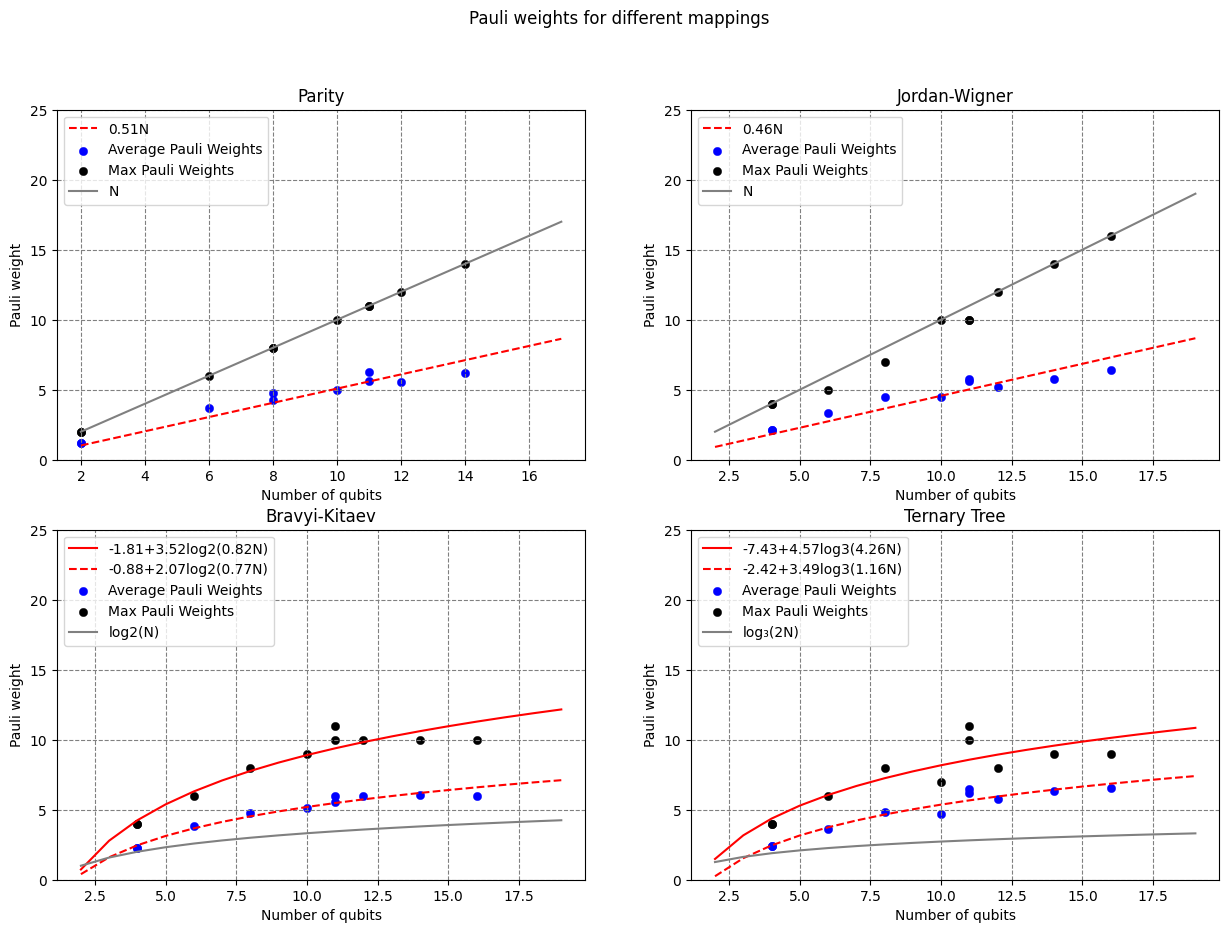

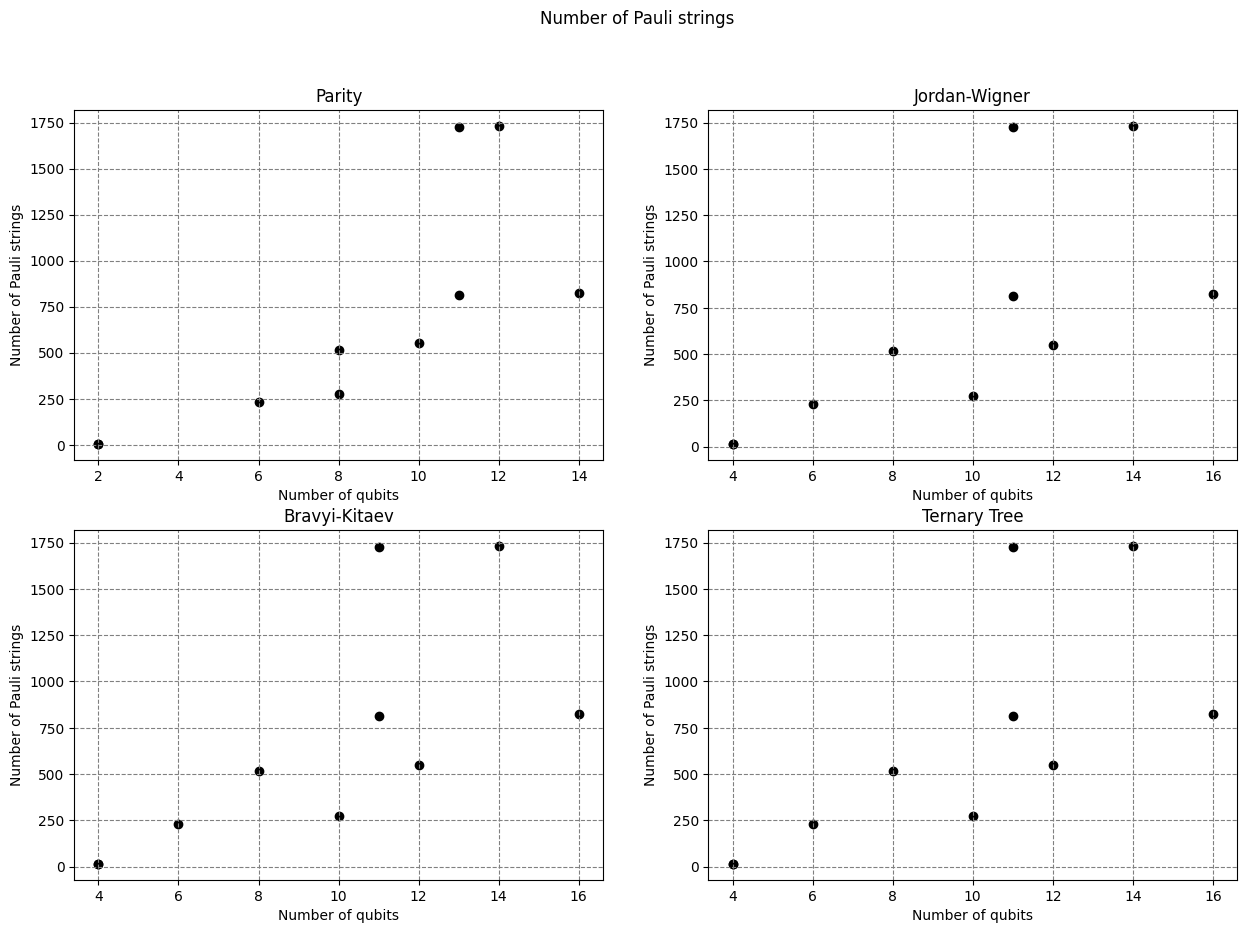

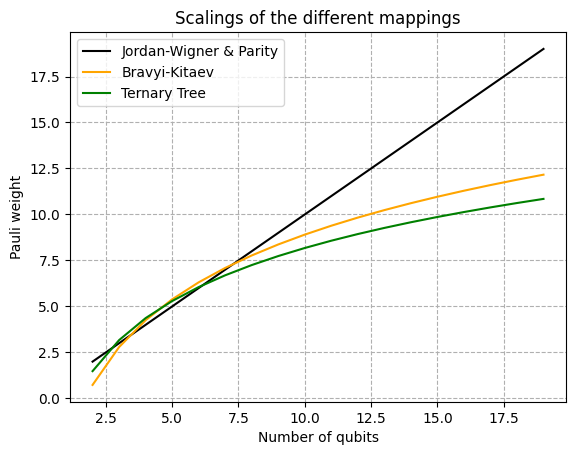

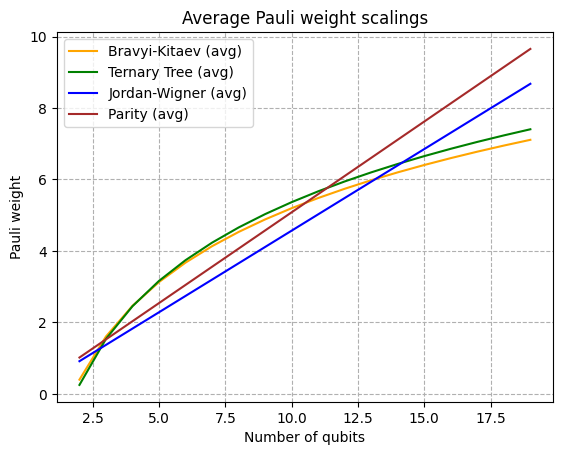

In [5]:
# Fermion-to-Qubit mapper reuslts' 
filename = 'all_hamiltonians.csv'
if(True):

        data = pd.read_csv('../results/'+filename)
        # reformat the data
        #dropping = ['ansatz', 'ansatz_circuit',
        #    'hamiltonian','vqe_energies', 'iterations',
        #    'exact_energies', 'exact_solution', 'parameters', 'error']
        #data = data.drop(columns=dropping)


        # Create a four figure sublot for the results
        fig, axs = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle('Pauli weights for different mappings')
        axs = axs.ravel()

        
        df_pauli_strings  = pd.DataFrame(columns=['Jordan-Wigner','Parity','Bravyi-Kitaev','Ternary Tree'],index=None)
        
        fig_n_ps,ax_n_ps = plt.subplots(2,2,figsize=figsize)
        fig_n_ps.suptitle('Number of Pauli strings')
        ax_n_ps = ax_n_ps.ravel()


        format = 'png'


        # Plot the the Pauli properties
        for ax,map,n_ps in zip(axs.flat,mappings,ax_n_ps.flat):
            print(map)


            # Filter the data
            if True:
                map_data = data[data['mapping']==map]
                num_qubits = list(map_data['num_qubits'])
                avg_pauli_weight = list(map_data['avg_pauli_weight'])
                avg_hardware_pauli_weight = list(map_data['avg_hardware_pauli_weight'])
                num_pauli_strings = list(map_data['num_pauli_strings'])
                max_pauli_weights = list(map_data['max_pauli_weight'])
                max_hrdwr_pauli_weights = list(map_data['max_hrdwr_pauli_weight'])


                # Create the range for the scaling
                plot_range = np.arange(2,(max(num_qubits)+4))


                train_x = [n for n in num_qubits]
                train_avg_y = [n for n in avg_pauli_weight]
                train_max_y = [n for n in max_pauli_weights]
                    
               
                if map == 'parity':
                    scaling = PR_scaling(plot_range)
                    name = 'Parity'
                    scaling_name='N'
                    init_guess = [1]
                    PR_avg_a, covariance = curve_fit(PR_scaling,train_x,train_avg_y, p0=init_guess)
                    ax.plot(plot_range, PR_scaling(plot_range,PR_avg_a),color=fit_color,linestyle='--',label=f"{PR_avg_a[0]:.2f}N")
                    shape = PR_shape
                    color = PR_color
                    size = 1.0
                    fc = 'none'
                    df_pauli_strings['Jordan-Wigner'] = (num_qubits,num_pauli_strings)



                elif map == 'jordan_wigner':
                    scaling = JW_scaling(plot_range)
                    name = 'Jordan-Wigner'
                    scaling_name='N'
                    init_guess = [1]
                    JW_avg_a, covariance = curve_fit(JW_scaling,train_x,train_avg_y, p0=init_guess)
                    ax.plot(plot_range, JW_scaling(plot_range,JW_avg_a),color=fit_color,linestyle='--',label=f"{JW_avg_a[0]:.2f}N")
                    shape = JW_shape
                    color = JW_color
                    size  = 0.8
                    fc = 'none'
                    df_pauli_strings['Parity'] = (num_qubits,num_pauli_strings)


                elif map == 'bravyi_kitaev':
                    scaling = BK_scaling(plot_range)
                    name = 'Bravyi-Kitaev'
                    scaling_name='log2(N)'

                    
                    init_guess = [1,1,1]
                    params, covariance = curve_fit(BK_scaling,train_x,train_max_y, p0=init_guess)
                    a,b,c = params
                    BK_a,BK_b,BK_c = a,b,c
                    

                    params, covariance = curve_fit(BK_scaling,train_x,train_avg_y, p0=init_guess)
                    BK_avg_a,BK_avg_b,BK_avg_c = params
                    

                    ax.plot(plot_range, BK_scaling(plot_range,a,b,c),color=fit_color ,label=f"{a:.2f}+{b:.2f}log2({c:.2f}N)")
                    ax.plot(plot_range, BK_scaling(plot_range,BK_avg_a,BK_avg_b,BK_avg_c),color=fit_color,linestyle='--',label=f"{BK_avg_a:.2f}+{BK_avg_b:.2f}log2({BK_avg_c:.2f}N)")
                    shape = BK_shape
                    color = BK_color
                    size =1.0
                    fc = None
                    df_pauli_strings['Bravyi-Kitaev'] = (num_qubits,num_pauli_strings)
                    

                elif map == 'neven':
                    scaling = OTT_scaling(plot_range)
                    name = 'Ternary Tree'
                    scaling_name='log₃(2N)'
                    init_guess = [1,1,1]

                    params, covariance = curve_fit(OTT_scaling,train_x,train_max_y, p0=init_guess)
                    a,b,c = params
                    OTT_a,OTT_b,OTT_c = a,b,c

                    params, covariance = curve_fit(OTT_scaling,train_x,train_avg_y, p0=init_guess)
                    OTT_avg_a,OTT_avg_b,OTT_avg_c = params


                    ax.plot(plot_range, OTT_scaling(plot_range,a,b,c), color=fit_color,label=f"{a:.2f}+{b:.2f}log3({2*c:.2f}N)")
                    ax.plot(plot_range, OTT_scaling(plot_range,OTT_avg_a,OTT_avg_b,OTT_avg_c),color=fit_color,linestyle='--',label=f"{OTT_avg_a:.2f}+{OTT_avg_b:.2f}log3({2*OTT_avg_c:.2f}N)")
                    shape = OTT_shape
                    color = OTT_color
                    size  = 1.0
                    fc = None
                    df_pauli_strings['Ternary Tree'] = (num_qubits,num_pauli_strings)
               

                    


                # Create scatter plot, since avg_pauli_weight can have multiple values for the same x values
                ax.scatter(num_qubits, avg_pauli_weight, color=avg_data_col,linewidth=dot_size, label='Average Pauli Weights')
                ax.scatter(num_qubits, max_pauli_weights, color=max_data_col,linewidth=dot_size, label='Max Pauli Weights')
                ax.plot(plot_range, scaling,color=theory_col, label=scaling_name)
                ax.set_xlabel('Number of qubits')
                ax.set_ylabel('Pauli weight')
                ax.legend(loc='upper left')
       

                ax.set_ylim(0, 25)
                
       
                # Add the title and grid Pauli weights
                ax.set_title(name)
                ax.grid(True, which='both', linestyle='--', color='grey')

                # Same for pauli strings plot
                n_ps.set_title(name)
                n_ps.scatter(num_qubits,num_pauli_strings,color='k')
                n_ps.grid(True, which='both', linestyle='--', color='grey')
                n_ps.set_xlabel('Number of qubits')
                n_ps.set_ylabel('Number of Pauli strings')   
        
        # Pauli string plot saving
        fig_n_ps.savefig('../results/num_pauli_strings.'+format,format=format,bbox_inches='tight',dpi=1000)
        fig_n_ps.show()
        
        
        # save figures
        plt.savefig('../results/Pauli_weights.'+format, format=format, bbox_inches = 'tight',dpi=1000)
        plt.show()
    
        # Plot the scalings only for mappings 
        plt.plot(plot_range, plot_range,color='k', label='Jordan-Wigner & Parity')
        plt.plot(plot_range, BK_scaling(plot_range,BK_a,BK_b,BK_c),color=BK_color, label='Bravyi-Kitaev')
        plt.plot(plot_range, OTT_scaling(plot_range,OTT_a,OTT_b,OTT_c),color=OTT_color, label='Ternary Tree')


        plt.xlabel('Number of qubits')
        plt.ylabel('Pauli weight')
        plt.legend()
        plt.title('Scalings of the different mappings')
        plt.grid('both',linestyle='--')
        plt.savefig('../results/pauli_weight_scalings.'+format, format=format, dpi=1000)
        plt.show()


        plt.plot(plot_range, BK_scaling(plot_range,BK_avg_a,BK_avg_b,BK_avg_c),color=BK_color, label='Bravyi-Kitaev (avg)')
        plt.plot(plot_range, OTT_scaling(plot_range,OTT_avg_a,OTT_avg_b,OTT_avg_c),color=OTT_color, label='Ternary Tree (avg)')
        plt.plot(plot_range, JW_scaling(plot_range,JW_avg_a),color=JW_color, label='Jordan-Wigner (avg)')
        plt.plot(plot_range, PR_scaling(plot_range,PR_avg_a),color=PR_color, label='Parity (avg)')
        plt.xlabel('Number of qubits')
        plt.ylabel('Pauli weight')
        plt.legend()
        plt.title('Average Pauli weight scalings')
        plt.grid('both',linestyle='--')
        plt.savefig('../results/avg_pauli_weight_scalings.'+format, format=format, dpi=1000)
        plt.show()

In [8]:
#Create a heat map for pauli weight an coefficient, to see  if they correlate
filename = 'all_hamiltonians.csv'
if(True):
        print('Checking if pauli weight and coefficient magnitude correlate')
        
        # Prepare the data
        data = pd.read_csv('../results/'+filename)
        hamiltonians = []
        hamiltonians = data['hamiltonian']
        #data.drop(columns=data.keys())
        print('Number of Hamiltonians '+str(len(hamiltonians)))
        
        
        pauli_weights  = []
        coeffs = []
        
        ham_string = hamiltonians[0]
        print(ham_string)
        paulis,coefficients = extract_pauli_and_coeffs(ham_string)
        for pauli,coeff in zip(paulis,coefficients):
            try: 
                fixed_coeff = float(abs(np.real(coeff)))
                pw = pauli_weight(pauli)
                if(pw==0):
                    continue
                coeffs.append(np.real(coeff))
                pauli_weights.append(pauli_weight(pauli))
            except:
                continue
    
        
        # add jittering
        ham_data = pd.DataFrame({'Pauli weight':list(pauli_weights),'Coefficient':list(coeffs)})
        
        plt.figure(figsize=figsize)
        #sns.scatterplot(data=ham_data, x='Pauli weight', y='Coefficient', color='blue', label='Data points')
        plt.scatter(pauli_weights,coeffs)
        #sns.regplot(data=ham_data, x='Pauli weight', y='Coefficient', scatter=False, color='orange', label='Line of Best Fit')
        plt.xlabel('Pauli weight')
        plt.ylabel('Coefficient magnitude')
        plt.show()


    

Checking if pauli weight and coefficient magnitude correlate
Number of Hamiltonians 40
SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81530017+0.j,  0.16988452+0.j, -0.21886307+0.j,  0.16988452+0.j,
 -0.21886307+0.j,  0.12005143+0.j,  0.16821199+0.j,  0.16549431+0.j,
  0.04544288+0.j,  0.04544288+0.j,  0.04544288+0.j,  0.04544288+0.j,
  0.16549431+0.j,  0.17395379+0.j,  0.12005143+0.j])


ValueError: No valid SparsePauliOp found in the string.

  molecule   vqe_time  num_qubits  \
0       H2  19.233049           4   

                                        vqe_energies  iterations  \
0  [-1.23749906148104, -1.229859324280772, -1.225...         133   

                                               error  \
0  [0.010852651936718027, 0.0184923891369857, 0.0...   

                                      exact_energies  exact_solution  \
0  [-1.248351713417758, -1.2483517134177577, -1.2...       -1.842687   

   num_parameters  gates  depth  ansatz_reps  classical_time  
0              16      3      8            1        0.002187  


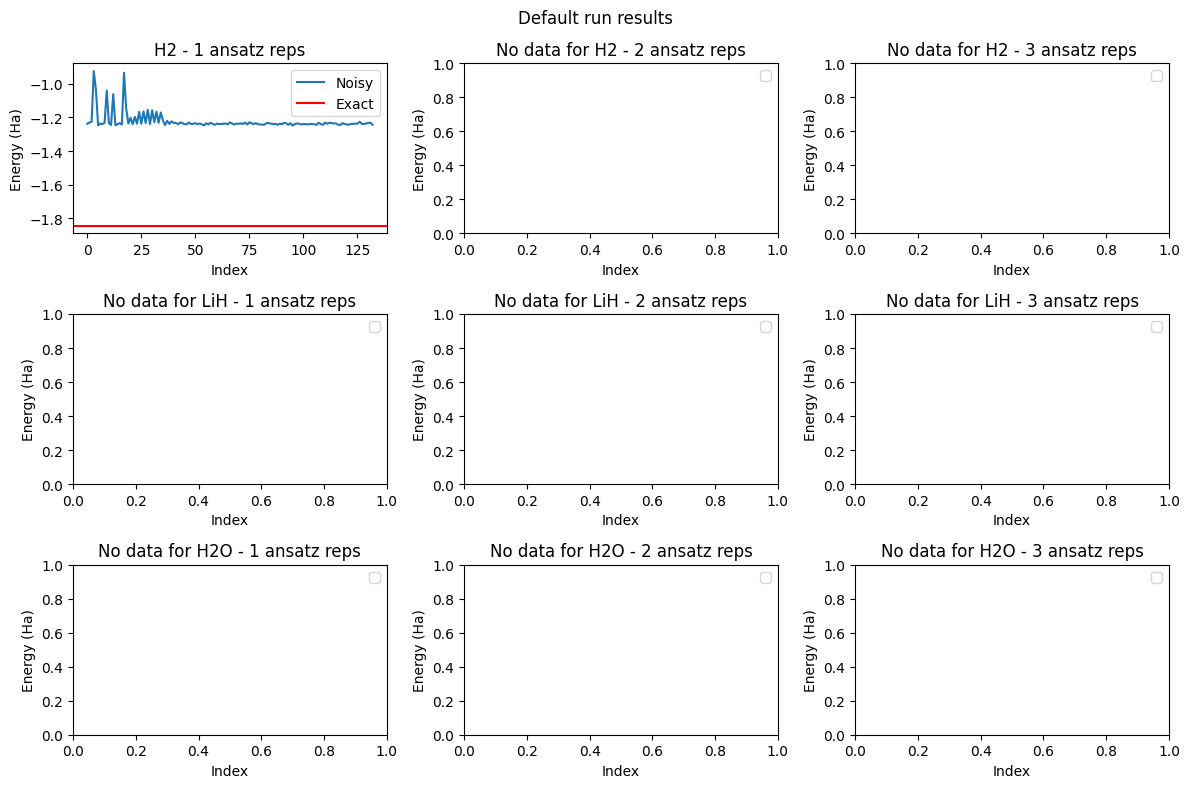

In [ ]:
# The default scheme
if(True):
        filename = 'default_run.csv'
        image_save_name = filename.split('.')[0]
        data = pd.read_csv('../results/' + filename)

        dropping = ['hamiltonian','ansatz',
                'avg_pauli_weight', 'mapping', 'num_pauli_strings', 
            'parameters', 'z2Symmetries',
            'avg_hardware_pauli_weight', 'max_pauli_weight', 'max_hrdwr_pauli_weight']

        data = data.drop(columns=dropping)

        molecules = ['H2', 'LiH', 'H2O']
        repetitions = [1, 2, 3]

        # Define figure size (for example)
        figsize = (12, 8)

        # Create subplots with 3 rows (one for each molecule) and 3 columns (one for each repetition)
        fig, axs = plt.subplots(3, 3, figsize=figsize)
        fig.suptitle('Default run results')

        # Flatte    n axes array for easy iteration
        axs = axs.ravel()

        # Iterate over molecules and repetitions, assigning each plot to the correct subplot
        for i, mol in enumerate(molecules):
            for j, rep in enumerate(repetitions):
                ax = axs[i * 3 + j]
                # Filter data for the given molecule and repetition
                filtered_data = data[(data['molecule'] == mol) & (data['ansatz_reps'] == rep)]

                if not filtered_data.empty:
                    # Plot the VQE energies if the data is available
                    vqe_energies = [float(elem) for elem in  filtered_data['vqe_energies'].to_list()[0].strip('[]').split(',')]
                    error = [float(e) for e in filtered_data['error'].to_list()[0].strip('[]').split(',')]  
                    exact_sol = float(filtered_data['exact_solution'])

                    ax.plot(vqe_energies, label='Noisy')
                    ax.axhline(y=exact_sol, color='r', linestyle='-', label='Exact')
                    # ad line with exact solution and mean error added
                    #ax.axhline(y=exact_sol+np.mean(error), color='g', linestyle='-', label='Exact + Mean error')
                    ax.set_title(f'{mol} - {rep} ansatz reps')
                else:
                    ax.set_title(f'No data for {mol} - {rep} ansatz reps')
        
                ax.set_xlabel('Index')
                ax.set_ylabel('Energy (Ha)')
                ax.legend()

        # Adjust layout and show the plot
        plt.tight_layout()
        plt.savefig('../results/'+image_save_name+'_convergence.png', format='png', dpi=1000)
        plt.show()

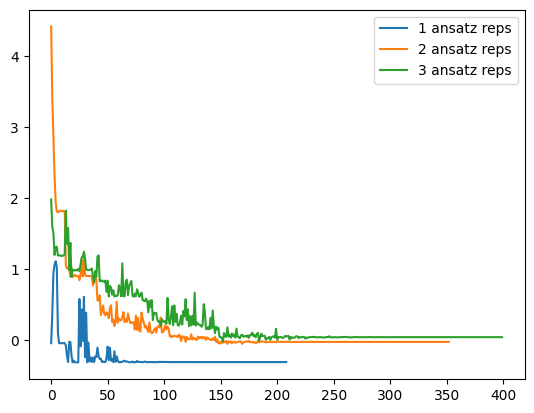

In [11]:
if(True):
        filename = 'LiH_run.csv'
        image_save_name = filename.split('.')[0]
        data = pd.read_csv('../results/' + filename)

        dropping = ['hamiltonian','ansatz',
                'avg_pauli_weight', 'mapping', 'num_pauli_strings', 
            'parameters', 'z2Symmetries',
            'avg_hardware_pauli_weight', 'max_pauli_weight', 'max_hrdwr_pauli_weight']

        data = data.drop(columns=dropping)

        repetitions = list(data['ansatz_reps'])

        for rep in repetitions:
            data_filtered = data[data['ansatz_reps']==rep]
            energies = [float(energy) for energy in eval(data_filtered['exact_energies'].values[0])]
            plt.plot(energies,label=f'{rep} ansatz reps')

        # add exact energy
        #plt.axhline(y=float(data_filtered['exact_solution']), color='r', linestyle='-', label='Exact')
        plt.legend()
        plt.show()

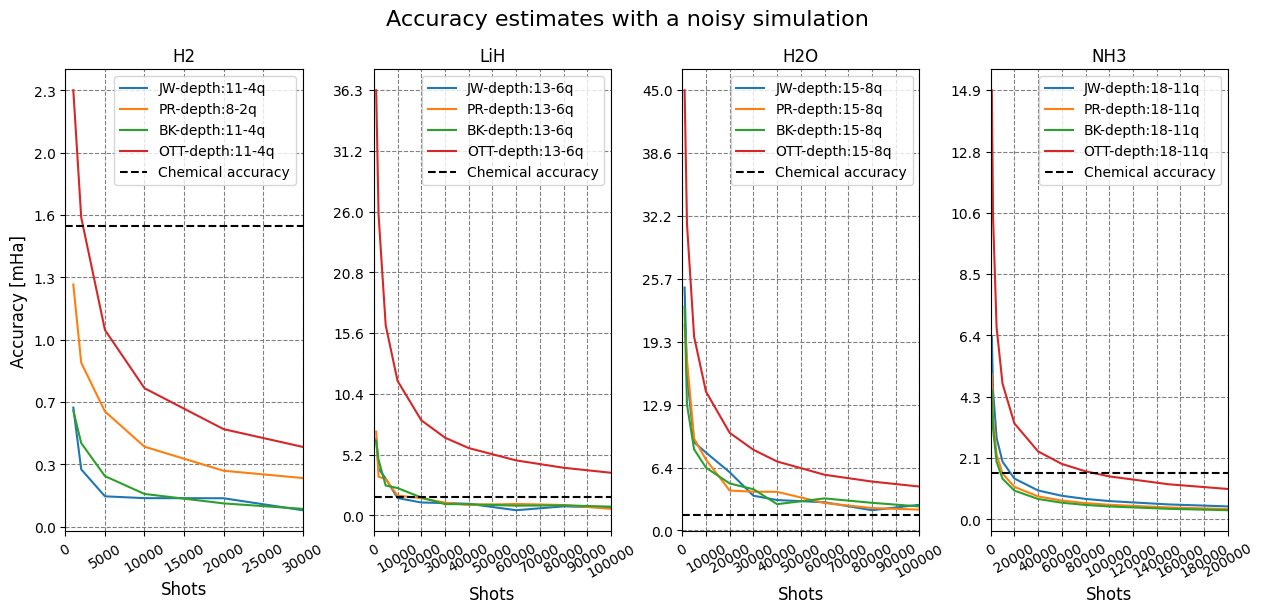

In [12]:
# Accuracy plots for Pauli scheme 
if(True):

        # plotting he estimated accuracy repsect to shots, comparing mappings
        #filename = 'accuracy_H2_run.csv'
        #filename = 'accuracy_LiH_run.csv'
        #filename = 'accuracy_H2O_run.csv'
        files = ['accuracy_H2_run.csv','accuracy_LiH_run.csv','accuracy_H2O_run.csv','accuracy_NH3_run.csv']


        figsize = (15,6)
        fig, axs = plt.subplots(1, 4, figsize=figsize)
        fig.suptitle('Accuracy estimates with a noisy simulation',fontsize=title_font)
        # set all subplots nice chunk apart of each other
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        axs = axs.ravel()
        axs[0].set_ylabel('Accuracy [mHa]',fontsize=axis_font)

        for ax,filename in zip(axs,files):
        
            image_save_name = filename.split('.')[0]
            data = pd.read_csv('../results/' + filename)
            # Columns of interest
            # num_qubits

            dropping = ['z2Symmetries','ansatz',
                                'vqe_time',           'hamiltonian',
                                'avg_pauli_weight',  'num_pauli_strings',
                                'vqe_energies',
                                'iterations',        'parameters',
                                'error',             'exact_energies',
                                'exact_solution',    'avg_hardware_pauli_weight',
                                'max_pauli_weight',  'max_hrdwr_pauli_weight',
                                'num_parameters',    'gates',
                                'ansatz_reps',
                                'classical_time',
                                ]


            acc_shots = list(data['accuracies_shots'])

            
            for map in all_maps:
                data_filtered = data[data['mapping']==map]
                num_qubits = data_filtered['num_qubits'].values[0]
                depth = data_filtered['depth'].values[0]
                name = mapping_renamer(map)
                acc_shots = eval(data_filtered['accuracies_shots'].values[0])
                ax.plot(acc_shots[1],acc_shots[0],label=name+'-depth:'+str(depth)+'-'+str(num_qubits)+'q')            
            # add y line for chemical accuracy limit
            ax.axhline(y=1.59e-3, color='k', linestyle='--', label='Chemical accuracy')
            ax.set_title(filename.split('_')[1].split('.')[0])
            ax.set_xlabel('Shots',fontsize=axis_font)
            #  make 10^-2 formate nicely
            #ax.set_ylabel('Accuracy [mHa]',fontsize=axis_font)

            
            # Set the the y axis to have 8 ticks
            ax.set_yticks(np.linspace(0,max(acc_shots[0]),8))
            
            # Set x ticks every 5000 units, from 0 to the maximum x value
            if filename == 'accuracy_H2O_run.csv' or filename == 'accuracy_LiH_run.csv':
                ax.set_xticks(np.arange(0, max(acc_shots[1]) + 1, 10_000))
                ax.set_xlim(0, max(acc_shots[1]))
            elif filename == 'accuracy_NH3_run.csv':
                ax.set_xticks(np.arange(0,max(acc_shots[1])+1, 20_000))
                ax.set_xlim(0,max(acc_shots[1]))
            else:
                ax.set_xticks(np.arange(0,max(acc_shots[1])+1, 5_000))
                ax.set_xlim(0,max(acc_shots[1]))

            # Rotate the x-axis tick labels 45 degrees
            ax.tick_params(axis='x', rotation=30)


            # set the y axis ticks to be showed to the second decimal
            ax.set_yticklabels(['{:,.1f}'.format(x*10**3) for x in ax.get_yticks()])

            
            # set a grwy dashed grid
            ax.grid(True, which='both', linestyle='--', color='grey')
            ax.legend()
        
       
        # add exact energy
        #plt.axhline(y=float(data_filtered['exact_solution']), color='r', linestyle='-', label='Exact')
        plt.savefig('../results/noisy_acc_data/accuracy_estimates_noisy.'+format, format=format, dpi=1000)
        #plt.savefig('../results/meas_schemes/QWC_accuracy_estimates.png', format='png', dpi=1000)
        
        plt.show()

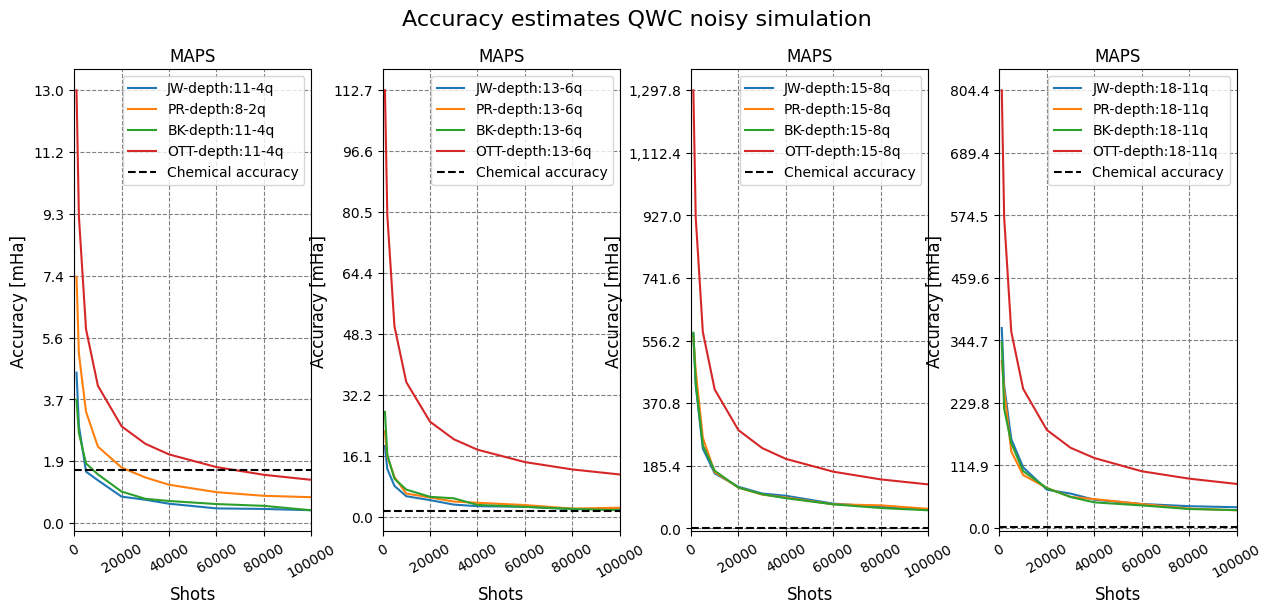

In [13]:

# Images for QWC accuracies
if(True):
         # plotting he estimated accuracy repsect to shots, comparing mappings
        filename = 'ALL_MAPS_QWC_accuracy_run.csv'
        data = pd.read_csv('../results/meas_schemes/' + filename)
        dropping = ['z2Symmetries','ansatz',
                                'vqe_time',           'hamiltonian',
                                'avg_pauli_weight',  'num_pauli_strings',
                                'vqe_energies',
                                'iterations',        'parameters',
                                'error',             'exact_energies',
                                'exact_solution',    'avg_hardware_pauli_weight',
                                'max_pauli_weight',  'max_hrdwr_pauli_weight',
                                'num_parameters',    'gates',
                                'ansatz_reps',
                                'classical_time','vqe_acc'
                                ]
        data.drop(columns=dropping)
        figsize = (15,6)
        fig, axs = plt.subplots(1, 4, figsize=figsize)
        fig.suptitle('Accuracy estimates QWC noisy simulation',fontsize=title_font)
        # set all subplots nice chunk apart of each other
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        axs = axs.ravel()


        for ax,mol in zip(axs,['H2','LiH','H2O','NH3']):

            # Columns of interest
            # num_qubits
            mol_data = data[data['molecule']==mol]

            for map in all_maps:
                data_filtered = mol_data[mol_data['mapping']==map]
                num_qubits = data_filtered['num_qubits'].values[0]
                depth = data_filtered['depth'].values[0]
                name = mapping_renamer(map)
                acc_shots = eval(data_filtered['accuracies_shots'].values[0])
                ax.plot(acc_shots[1],acc_shots[0],label=name+'-depth:'+str(depth)+'-'+str(num_qubits)+'q')            
            
            # add y line for chemical accuracy limit
            ax.axhline(y=1.59e-3, color='k', linestyle='--', label='Chemical accuracy')
            ax.set_title(filename.split('_')[1].split('.')[0])
            ax.set_xlabel('Shots',fontsize=axis_font)
            #  make 10^-2 formate nicely
            ax.set_ylabel('Accuracy [mHa]',fontsize=axis_font)

            
            # Set the the y axis to have 8 ticks
            ax.set_yticks(np.linspace(0,max(acc_shots[0]),8))
            
            ax.set_xticks(np.arange(0, max(acc_shots[1]) + 1, 20_000))
            ax.set_xlim(0, max(acc_shots[1]))

            # Rotate the x-axis tick labels 45 degrees
            ax.tick_params(axis='x', rotation=30)


            # set the y axis ticks to be showed to the second decimal
            ax.set_yticklabels(['{:,.1f}'.format(x*10**3) for x in ax.get_yticks()])

            
            # set a grwy dashed grid
            ax.grid(True, which='both', linestyle='--', color='grey')
            ax.legend()
        
       
        plt.savefig('../results/meas_schemes/QWC_accuracy_estimates.png', format='png', dpi=1000)
        
        plt.show()

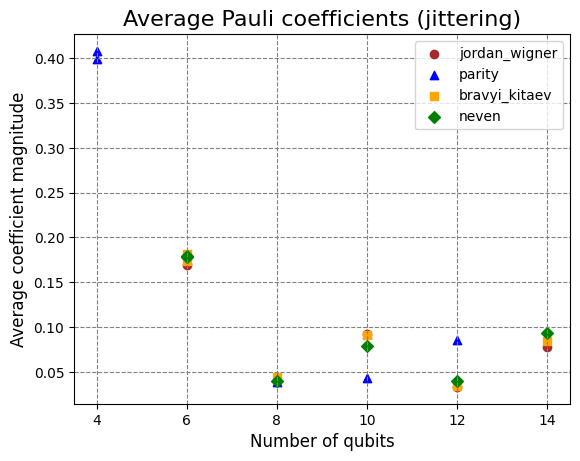

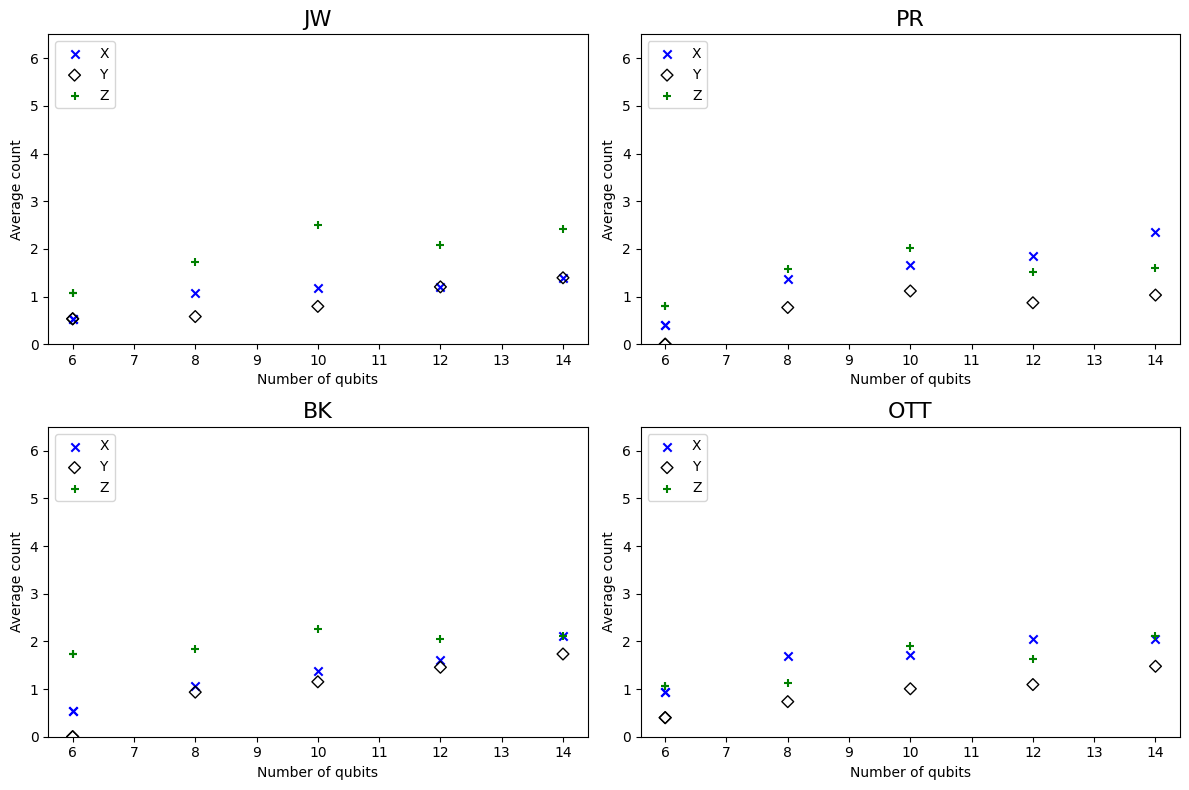

In [14]:
# plot the Pauli coefficients respect to qubit number 
if (True):
        ott_data= ()
        bk_data = ()
        pr_data = ()
        jw_data = ()
        all_data = [jw_data,pr_data,bk_data,ott_data]

        qubits = []
        xyz = []


        for map,shape,color in zip(all_maps,shapes,colors):
            num_qubits = []
            avg_coeffs = []
            num_x,num_y,num_z = [],[],[]
            
            for mol in molecules:
                for z2 in ['True','False']:
                                    
                    with open('../hamiltonians/'+mol+'-'+map+'-'+z2+'.txt','r') as file:
                        lines = file.readlines()
                        
                        num_qubits.append(int(len(str(lines[0]).split('*')[1])))
                        jitter = np.random.normal(0,0.005)
                        avg_coeffs.append(np.mean([np.abs(np.real(eval(str(line).split('*')[0]))) for line in lines])+jitter)
                        paulis = [str(line).split('*')[1] for line in lines]

                        
                        x,y,z = num_x_y_z(paulis)
                        num_x.append(x)
                        num_y.append(y)
                        num_z.append(z)


                    qubits.append(num_qubits)
            xyz.append([num_x,num_y,num_z])
            #print(len(qubits),len(num_x),len(num_y),len(num_z))

                   
            # use the given shape ad color
            plt.scatter(num_qubits,avg_coeffs,color=color,marker=shape,label=map)
            
        plt.title('Average Pauli coefficients (jittering)',fontsize=title_font)
        plt.xlabel('Number of qubits',fontsize=axis_font)
        plt.ylabel('Average coefficient magnitude',fontsize=axis_font)
        plt.legend()
        # add a grey dashed grid 
        plt.grid(True, which='both', linestyle='--', color='grey')
        plt.savefig('../results/average_coefficients.png', format='png', dpi=1000)
        plt.show()
                                    


        # Create a figure with 4 subplots in a 2x2 grid
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))

        # Flatten the axes array for easy iteration
        axs = axs.flatten()

        # Loop through each map and corresponding data to plot on each subplot
        for i, (map_name, n_qubits, xyz_map) in enumerate(zip(all_maps, qubits, xyz)):
            ax = axs[i]
            ax.scatter(n_qubits, xyz_map[0], color='b', marker='x', label='X')
            ax.scatter(n_qubits, xyz_map[1], color='k', marker='D', facecolors='none', label='Y')
            ax.scatter(n_qubits, xyz_map[2], color='g', marker='+', label='Z')
    
            name = mapping_renamer(map_name)
            ax.set_title(name,fontsize=title_font)
            ax.set_xlabel('Number of qubits')
            ax.set_ylabel('Average count')
            # set x ticks to be integers
            ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            # set y limit 0 to .5
            ax.set_ylim(0,6.5)
            ax.legend(loc='upper left')

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.savefig('../results/average_xyz.png', format='png', dpi=1000)
        plt.show()

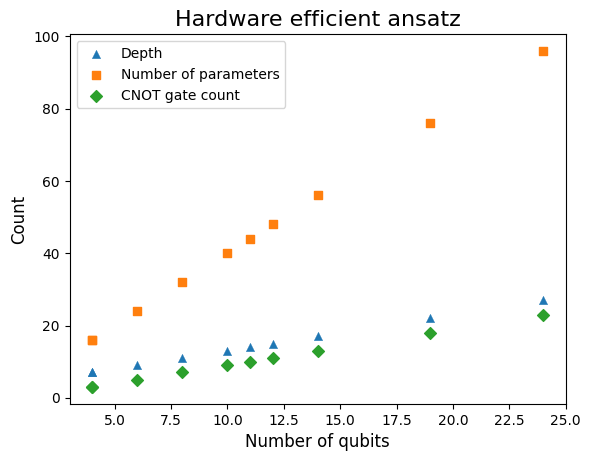

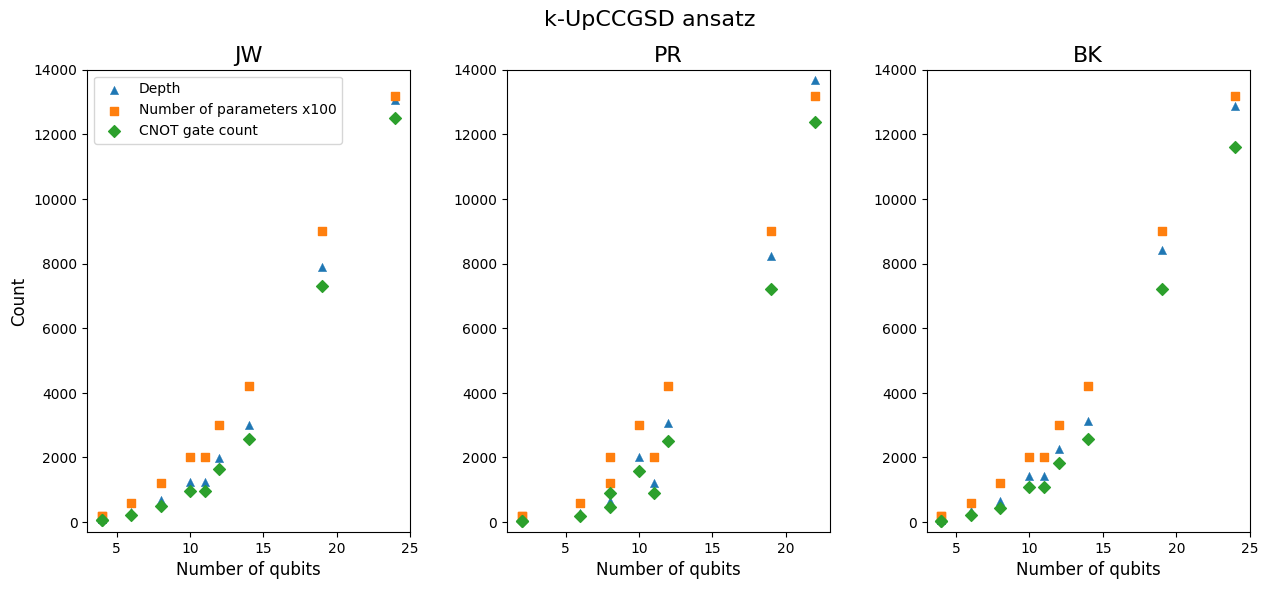

<Figure size 640x480 with 0 Axes>

In [15]:

# Plot to compare ansatz scaling
if (True):
        HEA_file = '../results/ansatz_data/HEA_check.csv'
        kUpCCGSD_file = '../results/ansatz_data/k-UpCCGSD_check.csv'
        
        # read in the data
        HEA_data = pd.read_csv(HEA_file)
        kUpCCGSD_data = pd.read_csv(kUpCCGSD_file)
        dropping = ['z2Symmetries',
                                'vqe_time',           'hamiltonian',
                                'avg_pauli_weight',  'num_pauli_strings',
                                'vqe_energies',
                                'iterations',        'parameters',
                                'error',             'exact_energies',
                                'exact_solution',    'avg_hardware_pauli_weight',
                                'max_pauli_weight',  'max_hrdwr_pauli_weight',
                                'classical_time','vqe_acc'
                                ]
        HEA_data.drop(columns=dropping)
        kUpCCGSD_data.drop(columns=dropping)

        # Plot the HEA num_paramter, gates and depth respct to qubits

        figsize = (15,6)
        plt.title('Hardware efficient ansatz',fontsize=title_font)
        plt.scatter(HEA_data['num_qubits'],HEA_data['depth'],linewidth=dot_size,marker=PR_shape,label='Depth')
        plt.scatter(HEA_data['num_qubits'],HEA_data['num_parameters'],marker=BK_shape,label='Number of parameters')
        plt.scatter(HEA_data['num_qubits'],HEA_data['gates'],marker = OTT_shape,label='CNOT gate count')

        plt.xlabel('Number of qubits',fontsize=axis_font)
        plt.ylabel('Count',fontsize=axis_font)

        plt.legend(loc='upper left')
        plt.savefig('../results/ansatz_data/HEA_check.png', format='png', dpi=1000)
        
        plt.show()
        
        # Plot the k-UpCCGSD num_paramter, gates and depth respct to qubits
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle('k-UpCCGSD ansatz',fontsize=title_font)
        # set all subplots nice chunk apart of each other
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        axs = axs.ravel()

        i=0
        for map,ax in zip(['jordan_wigner','parity','bravyi_kitaev'],axs):
            map_data = kUpCCGSD_data[kUpCCGSD_data['mapping']==map]
            ax.scatter(map_data['num_qubits'],map_data['depth'],linewidth=dot_size,marker=PR_shape,label='Depth')
            ax.scatter(map_data['num_qubits'],map_data['num_parameters']*100,marker=BK_shape,label='Number of parameters x100')
            ax.scatter(map_data['num_qubits'],map_data['gates'],marker = OTT_shape,label='CNOT gate count')

            ax.set_title(mapping_renamer(map),fontsize=title_font)
            ax.set_xlabel('Number of qubits',fontsize=axis_font)
            ax.set_ylim(-300,14000)
            if (i==0):
                ax.set_ylabel('Count',fontsize=axis_font)
                ax.legend(loc='upper left')
                i+=1
        plt.show()
        plt.savefig('../results/ansatz_data/k-UpCCGSD_check.png', format='png', dpi=dpi)

In [16]:

# Plot exact energies for each molecule
if (True):
        molecules = ['H2','LiH','H2O','NH3']
        file = 'hamiltonian_results.csv'
        data = pd.read_csv('../results/'+file)
        relevant_columns = ['molecule','mapping','num_qubits','z2Symmetries','exact_solution']
        
        data = data[relevant_columns]

        data_length = len(data)
        # Print the dataframe 
        print(data.head(data_length))

        mappings = [mapping_renamer(map) for map in data['mapping']]
        data['mapping'] = mappings
        
        print(data.head(data_length))
        for mol,map,qubits,z2,exact in zip(data['molecule'],data['mapping'],data['num_qubits'],data['z2Symmetries'],data['exact_solution']):
            # round exact to three digits 
            exact = round(exact,3)
            print(mol+'-'+map+'-'+str(qubits)+'q-z2:'+str(z2)+' & '+str(exact)+'\\\\')
        # set all subplots nice chunk apart of each other
        #for mol,ax in zip(molecules,axs):
        #    molecule_data = data[data['molecule']==mol]
        #   for map,shape,color in zip(all_maps,shapes,colors):
        #        data_filtered = molecule_data[molecule_data['mapping']==map]
        #        for z2 in [True,False]:
        #            if (z2==False):
        #                color = 'black'

         #           data_filtered = data_filtered[data_filtered['z2Symmetries']==z2]
         #           name = mapping_renamer(map)
         #           exact_solution = data_filtered['exact_solution'].values
                
        #            for x in exact_solution:
        #                solution = x

                    
                   
        ##    if(i==0):
         #       ax.set_ylabel('Energy [Ha]',fontsize=axis_font)
         #       ax.legend(loc='upper left')
         #       i+=1
         #   ax.set_xlabel('',fontsize=axis_font)

        #plt.show()


   molecule        mapping  num_qubits  z2Symmetries  exact_solution
0        H2  jordan_wigner           4         False       -1.842687
1        H2         parity           2         False       -1.842687
2        H2  bravyi_kitaev           4         False       -1.842687
3        H2          neven           4         False       -1.842687
4        H2  jordan_wigner           4          True       -1.842687
5        H2         parity           2          True       -1.842687
6        H2  bravyi_kitaev           4          True       -1.842687
7        H2          neven           4          True       -1.842687
8       LiH  jordan_wigner          10         False       -1.078084
9       LiH         parity           8         False       -1.078084
10      LiH  bravyi_kitaev          10         False       -1.078084
11      LiH          neven          10         False       -1.078084
12      LiH  jordan_wigner           6          True       -0.961993
13      LiH         parity        

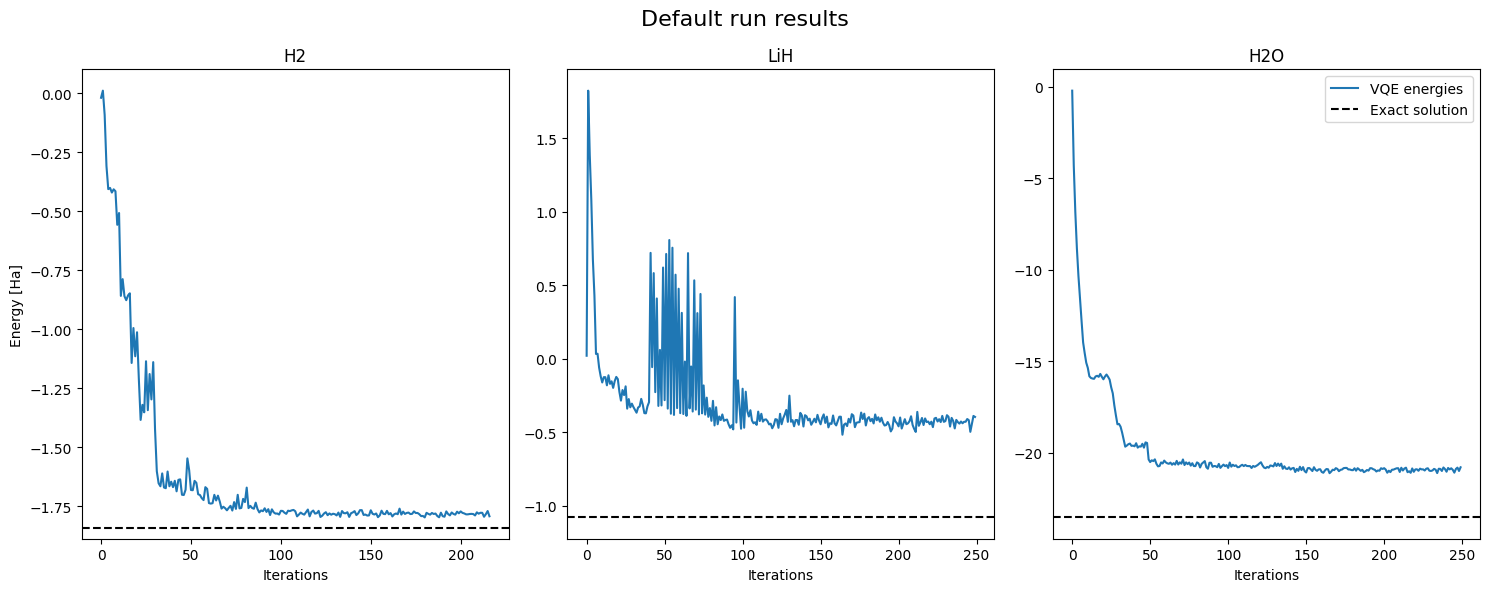

0        28.579921
1     11359.545294
2    100908.999958
Name: vqe_time, dtype: float64


<Figure size 640x480 with 0 Axes>

In [18]:

# Plot convergence for VQE runs
if (True):
        file = 'default_run_1.csv'
        data = pd.read_csv('../results/default_runs/'+file)
        

        dropping = ['hamiltonian','ansatz',
                'avg_pauli_weight', 'mapping', 'num_pauli_strings', 
            'parameters', 'z2Symmetries',
            'avg_hardware_pauli_weight', 'max_pauli_weight', 'max_hrdwr_pauli_weight']

        data = data.drop(columns=dropping)

        molecules = ['H2', 'LiH', 'H2O']


        # Create subplots with 3 rows (one for each molecule) and 3 columns (one for each repetition)
        fig, axs = plt.subplots(1, 3, figsize=figsize)
        fig.suptitle('Default run results',fontsize=title_font)

        # Flatte    n axes array for easy iteration
        axs = axs.ravel()

        axs[0].set_ylabel('Energy [Ha]')
        
        for mol,ax in zip(molecules,axs):
            #print(eval(data[data['molecule']==mol]['vqe_energies'].values[0]))
            ax.title.set_text(mol)
            error = eval(data[data['molecule']==mol]['error'].values[0])
            # vqe energies with error margins
            vqe = eval(data[data['molecule']==mol]['vqe_energies'].values[0])
            ax.plot(vqe,label='VQE energies')
            ax.axhline(y=float(data[data['molecule']==mol]['exact_solution'].values[0]), color='k', linestyle='--', label='Exact solution')
            ax.set_xlabel('Iterations')

        # Adjust layout and show the plot
        axs[2].legend(loc='upper right')
        plt.tight_layout()
        plt.show()
        plt.savefig('../results/default_runs/default_run_1.'+format, format=format, dpi=400)

        print(data['vqe_time'])

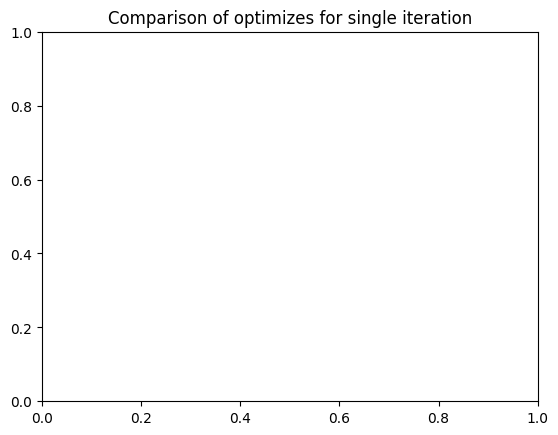

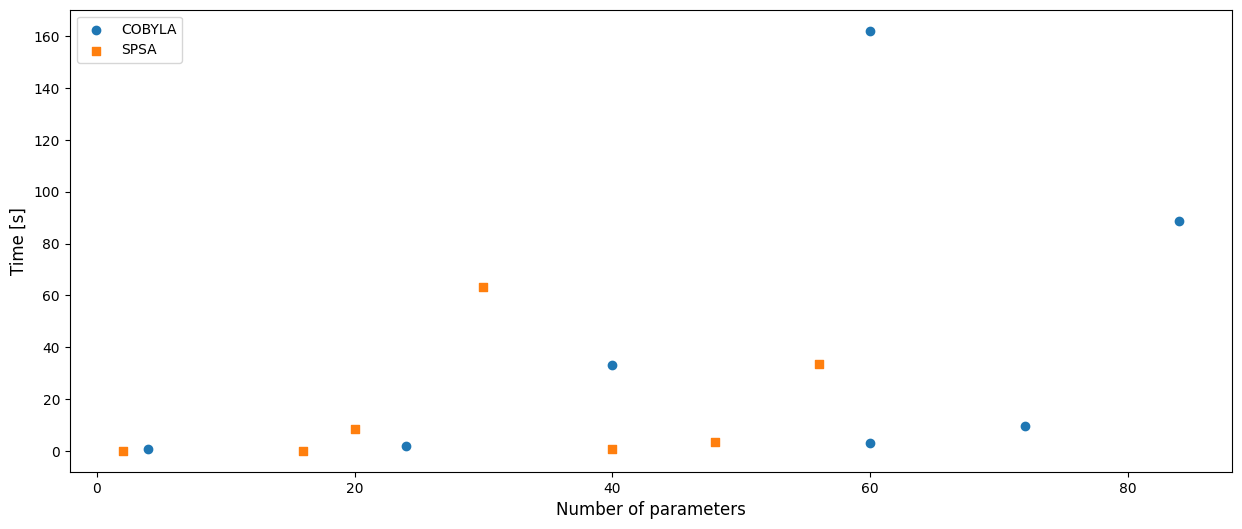

<Figure size 640x480 with 0 Axes>

In [ ]:

# Optimizer and ansatz performance
if (True):
        cobyla = 'cobyla_ansatzes.csv'
        spsa = 'spsa_ansatzes.csv'
        cob_data = pd.read_csv('../results/optimizer_data/'+cobyla)
        spsa_data = pd.read_csv('../results/optimizer_data/'+spsa)

        # bothcreted using 1 shot
        # Relevant columns
        cols = ['num_qubits','vqe_time','iterations','num_parameters']

        cob_data = cob_data[cols]
        spsa_data = spsa_data[cols]

        spsa_iters = list(spsa_data['iterations'].values)

      

        spsa_times = [time/iter for time,iter in zip(spsa_data['vqe_time'],spsa_iters)]

        # Set the figure size
        plt.title('Comparison of optimizes for single iteration')
        plt.figure(figsize=figsize)
        plt.scatter(list(cob_data['num_parameters'].values),list(cob_data['vqe_time'].values),marker = JW_shape,label='COBYLA')
        plt.scatter(list(spsa_data['num_parameters'].values),spsa_times,marker=BK_shape,label='SPSA')

        plt.xlabel('Number of parameters',fontsize=axis_font)
        plt.ylabel('Time [s]',fontsize=axis_font)
        plt.legend(loc='upper left')
        plt.show()
        plt.savefig('../results/optimizer_data/optimizers_ansatzes.'+format, format=format, dpi=400)


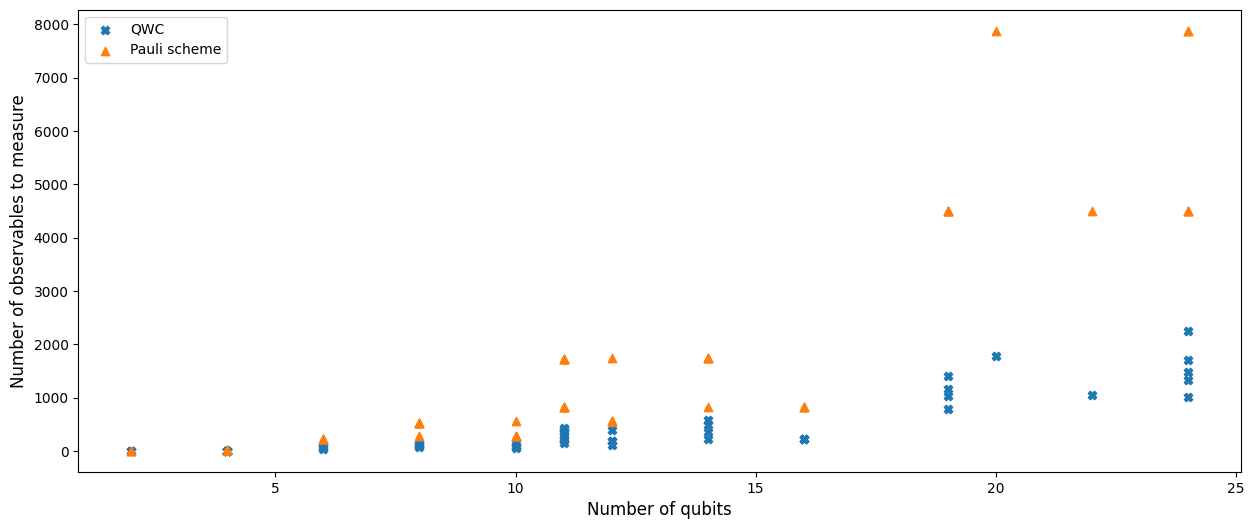

<Figure size 640x480 with 0 Axes>

In [20]:

# Number of observables to measure
if (True):

        # read in all the files fro ../hamiltonians/*txt
        files = os.listdir('../hamiltonians/')
        num_qubits = []
        num_groups = []
        num_paulis = []    
        # read the hamiltonian from eac hfile 
        plt.figure(figsize=figsize)
    
        for file in files:
            hamiltonian  = retrieve_ham('../hamiltonians/'+file) 
            num_qubits.append(len(hamiltonian.paulis[0]))
            num_groups.append(len(hamiltonian.group_commuting(qubit_wise=True)))
            num_paulis.append(len(hamiltonian.paulis))


        plt.scatter(num_qubits,num_groups,marker='X',label='QWC')
        plt.scatter(num_qubits,num_paulis,marker=PR_shape,label='Pauli scheme')
        plt.xlabel('Number of qubits',fontsize=axis_font)
        plt.ylabel('Number of observables to measure',fontsize=axis_font)
        plt.legend(loc='upper left')
        plt.show()
        plt.savefig('../results/meas_schemes/number_observable.'+format, format=format, dpi=400)

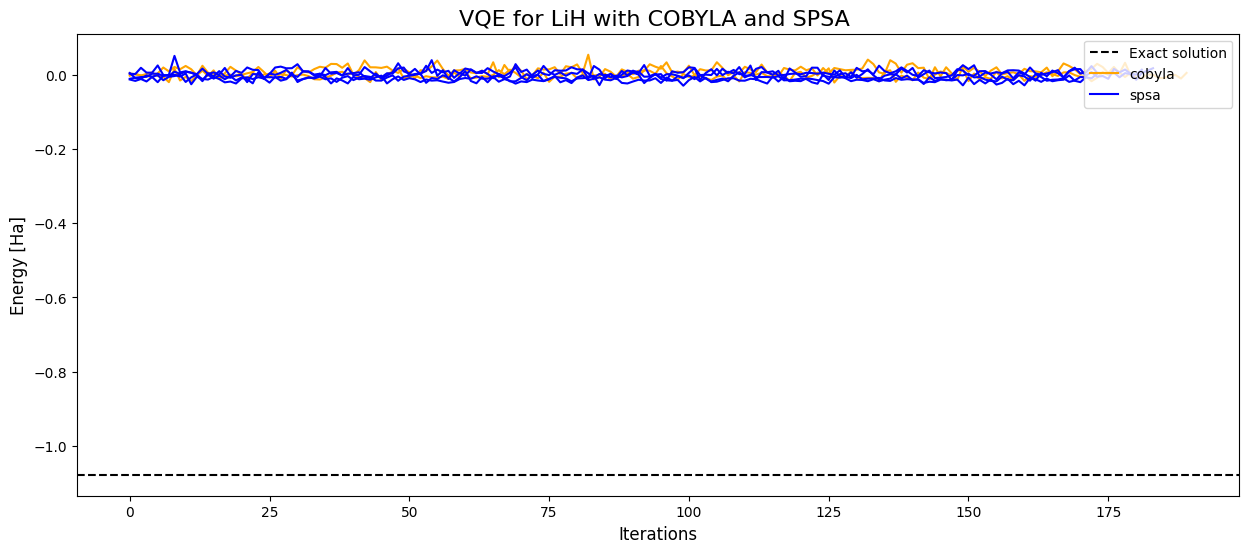

Avg cob time: 3148.921731710434
Avg spsa time: 5581.729495763779


<Figure size 640x480 with 0 Axes>

In [21]:

# Lih runs for both opimizers
if (True):
        
        cob_files = ['LiH_cobyla_run_1.csv','LiH_cobyla_run_2.csv','LiH_cobyla_run_3.csv','LiH_cobyla_run_4.csv']
        spsa_files = ['LiH_spsa_run_1.csv','LiH_spsa_run_2.csv','LiH_spsa_run_3.csv','LiH_spsa_run_4.csv']

        columns = ['iterations','vqe_time','exact_solution','vqe_energies']

        exact_solution = pd.read_csv('../results/optimizer_data/LiH_cobyla_run_1.csv')['exact_solution'].values[0]
        cob_times = []
        spsa_times = []

        
        # Plot the cobyla data
        plt.figure(figsize=figsize)
        plt.title('VQE for LiH with COBYLA and SPSA ',fontsize=title_font)
        plt.axhline(y=exact_solution, color='k', linestyle='--', label='Exact solution')
        i = 0
        for file in cob_files:
            data = pd.read_csv('../results/optimizer_data/'+file)
            data = data[columns]
            cob_times.append(data['vqe_time'].values[0])
        
            if (i==0):
                plt.plot(eval(data['vqe_energies'].values[0]),color= BK_color,label='cobyla')
                i+=1
            else:
                plt.plot(eval(data['vqe_energies'].values[0]), color =BK_color)
        i=0
        for file in spsa_files:
            data = pd.read_csv('../results/optimizer_data/'+file)
            data = data[columns]
            spsa_times.append(data['vqe_time'].values[0])

            if (i==0):
                plt.plot(eval(data['vqe_energies'].values[0]),color=JW_color,label='spsa')
                i+=1
            else:
                plt.plot(eval(data['vqe_energies'].values[0]), color = JW_color)

        plt.xlabel('Iterations',fontsize=axis_font)
        plt.ylabel('Energy [Ha]',fontsize=axis_font)
        plt.legend(loc='upper right')
        plt.show()
        plt.savefig('../results/optimizer_data/LiH_optimizers.'+format, format=format, dpi=400)

        print('Avg cob time:',np.mean(cob_times))
        print('Avg spsa time:',np.mean(spsa_times))